# **OVERVIEW**

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.


Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.


While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# **DATA**

`application_{train|test}.csv`

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

`bureau.csv`

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

`bureau_balance.csv`

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

`credit_card_balance.csv`

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

`previous_application.csv`

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

`installments_payments.csv`

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

`HomeCredit_columns_description.csv`

This file contains descriptions for the columns in the various data files.

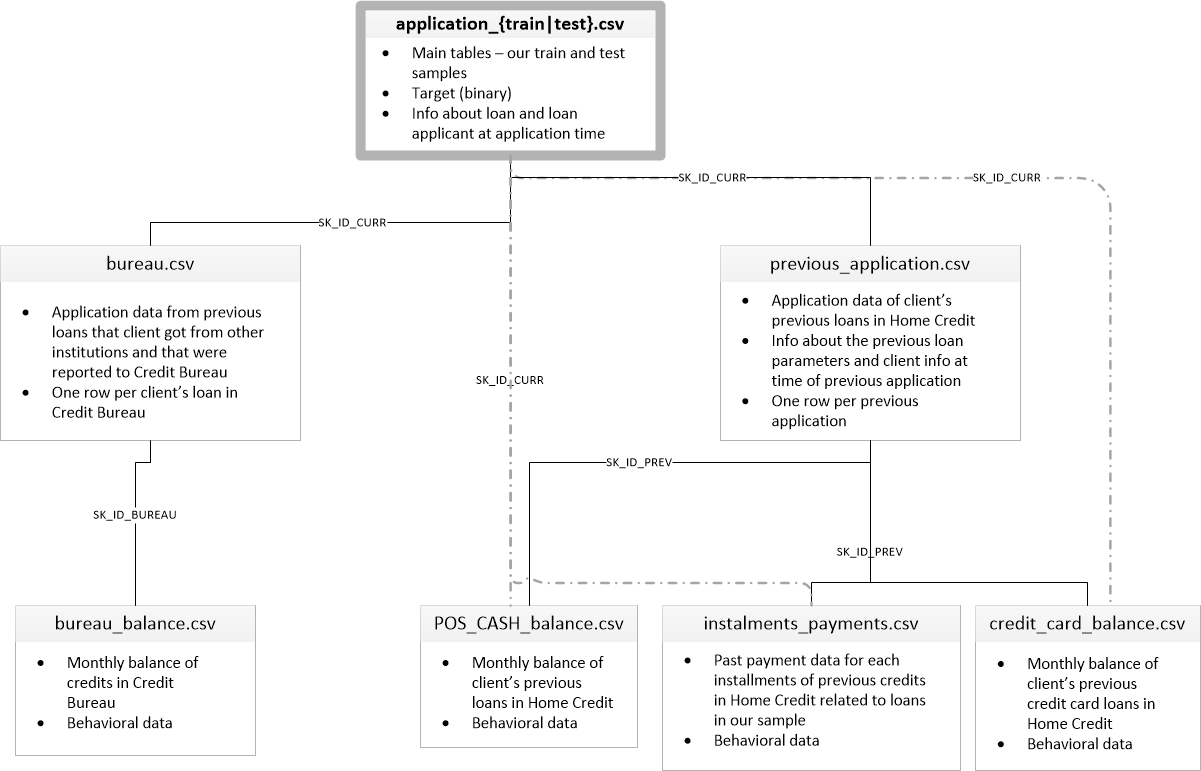)

As seen in Figure 1, the file application_{train|test}.csv contains the main table containing the training dataset (307511 samples) and test dataset (48744 samples), with each row representing one loan identified by the feature SK_ID_CURR. 

The training set contains the variable TARGET with binary values 
(
  0: the loan was repaid or 
  1: the loan was not repaid
). 

There are many input files available, which will be analysed for input features to train the model. The large number of input features and training samples will allow me to identify the important factors and for constructing a credit default risk classification model.

# **PROBLEM STATEMENT**

The problem and associated data has been provided by Home Call Credit Group for a Kaggle competition. The problem can be described as, “A binary classification problem where the inputs are various features describing the financial and behavioral history of the loan applicants, in order to predict whether the loan will be repaid or defaulted.”

## Project Novelty
The notebook provides a complete end-to-end workflow for building a binary classifier, and includes methods like automated feature engineering for connecting relational databases, comparison of different classifiers on imbalanced data, and hyperparameter tuning using Bayesian optimization.

## Project Design and Solution

**The project has been divided into five parts-**

`Data Preparation` - Before starting the modeling, we need to import the necessary libraries and the datasets. If there are more than one files, then all need to be imported before we can look at the feature types and number of rows/columns in each file.

`Exploratory Data Analysis` - After data importing, we can investigate the data and answer questions like- How many features are present and how are they interlinked? What is the data quality, are there missing values? What are the different data types, are there many categorical features? Is the data imbalanced? And most importantly, are there any obvious patterns between the predictor and response features?

`Feature Engineering` - After exploring the data distributions, we can conduct feature engineering to prepare the data for model training. This includes operations like replacing outliers, imputing missing values, one-hot encoding categorical variables, and rescaling the data. Since there are number of relational databases, we can use extract, transform, load (ETL) processes using automated feature Engineering with Featuretools to connect the datasets. The additional features from these datasets will help improve the results over the base case (logistic regression).

`Classifier Models`: Training, Prediction and Comparison - After the dataset is split into training and testing sets, we can correct the data imbalances by undersampling the majority class. Then, we can training the different classifier models (Logistic Regression, Random Forest, Decision Tree, Gaussian Naive Bayes, XGBoost, Gradient Boosting, LightGBM) and compare their performance on the test data using metrics like accuracy, F1-score and ROC AUC. After choosing the best classifier, we can use K-fold cross validation to select the best model. This will help us choose parameters that correspond to the best performance without creating a separate validation dataset.

`Hyperparameter Tuning` - After choosing the binary classifier, we can tune the hyperparameters for improving the model results through grid search, random search, and Bayesian optimization (Hypertopt library). The hyperparameter tuning process will use an objective function on the given domain space, and an optimization algorithm to give the results. The ROC AUC validation scores from all three methods for different iterations can be compared to see trends.

# **File and Lib import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
bureau = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bureau_10k.csv")
bureau_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bureau_balance_10k.csv")
credit_card_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/credit_card_balance_10k.csv")
installments_payments = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/installments_payments_10k.csv")
pos_cash_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pos_cash_balance_10k.csv")
previous_application = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/previous_application_10k.csv")

application_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/application_train.csv")
application_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/application_test.csv")


data_dictionary = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data_Dictionary.csv")


In [4]:
#@title Number of Rows in every file
print('application_train: ', application_train.shape)
print('application_test: ',application_test.shape)
print('bureau: ', bureau.shape)
print('bureau_balance: ',bureau_balance.shape)
print('credit_card_balance: ',credit_card_balance.shape)
print('installments_payments: ',installments_payments.shape)
print('pos_cash_balance: ',pos_cash_balance.shape)
print('previous_application: ',previous_application.shape)

application_train:  (307511, 122)
application_test:  (48744, 121)
bureau:  (10000, 18)
bureau_balance:  (10000, 4)
credit_card_balance:  (10000, 24)
installments_payments:  (10000, 9)
pos_cash_balance:  (10000, 9)
previous_application:  (10000, 38)


Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

In [5]:
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

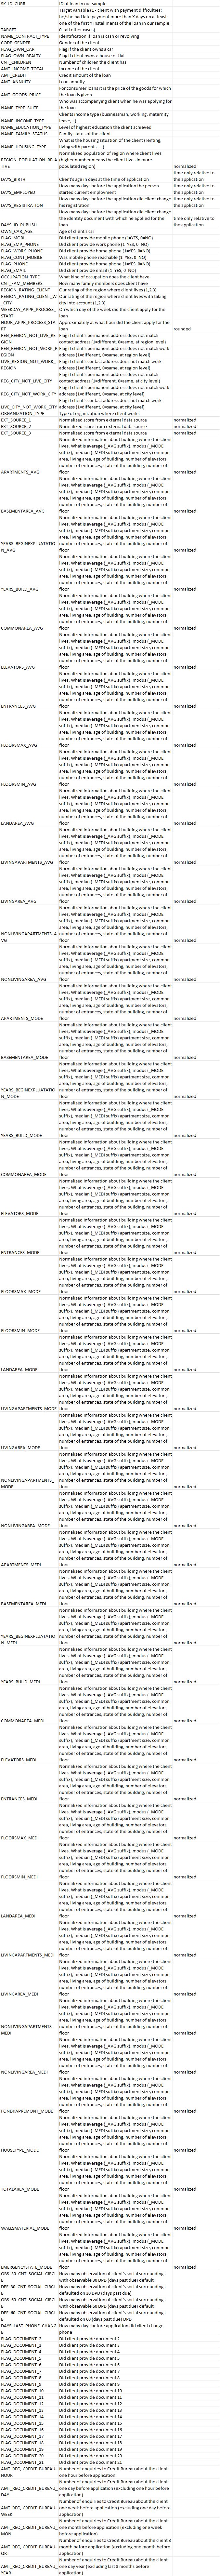

In [6]:
#@title Non-Numeric Columns in application_train.csv
non_numeric_application_train = application_train.select_dtypes(include='object').columns
non_numeric_application_train.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
#@title Numeric Columns in application_train.csv
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_application_train = application_train.select_dtypes(include=numerics)
numeric_columns_application_train = numeric_application_train.columns.tolist()[2:]
numeric_columns_application_train

In [8]:
#@title Missing Data in application_train
miss_data = pd.DataFrame((numeric_application_train.isnull().sum())*100/application_train.shape[0]).reset_index()
null_numeric_columns = miss_data[miss_data[0]>0]['index'].tolist()

In [9]:
#@title Divide the days by 365. Convert it into approx years. 

# DAYS_BIRTH_YEAR - Divide values in column by 365
# DAYS_EMPLOYED_YEAR - Divide values in column by 365
# DAYS_REGISTRATION_YEAR - Divide values in column by 365
# DAYS_ID_PUBLISH_YEAR - Divide values in column by 365
# OWN_CAR_AGE_YEAR - Divide values in column by 365

def DAYS_BIRTH_YEAR(row):
    if abs(row['DAYS_BIRTH'])>0: 
      val =  round(abs(row['DAYS_BIRTH']) / 365)
    else:
      val = 0
    return val

application_train['DAYS_BIRTH'] = application_train.apply(DAYS_BIRTH_YEAR, axis=1)

def DAYS_EMPLOYED_YEAR(row):
    if abs(row['DAYS_EMPLOYED'])>0: 
      val =  round(abs(row['DAYS_EMPLOYED']) / 365)
    else:
      val = 0
    return val

application_train['DAYS_EMPLOYED'] = application_train.apply(DAYS_EMPLOYED_YEAR, axis=1)

def DAYS_REGISTRATION_YEAR(row):
    if abs(row['DAYS_REGISTRATION'])>0: 
      val =  round(abs(row['DAYS_REGISTRATION']) / 365)
    else:
      val = 0
    return val

application_train['DAYS_REGISTRATION'] = application_train.apply(DAYS_REGISTRATION_YEAR, axis=1)

def DAYS_ID_PUBLISH_YEAR(row):
    if abs(row['DAYS_ID_PUBLISH'])>0: 
      val =  round(abs(row['DAYS_ID_PUBLISH']) / 365)
    else:
      val = 0
    return val

application_train['DAYS_ID_PUBLISH'] = application_train.apply(DAYS_ID_PUBLISH_YEAR, axis=1)



In [12]:
#@title Imputation of Null values for Numeric Columns

for x in null_numeric_columns:
  median = round(application_train[x].median())
  application_train[x] = application_train[x].fillna(median) 

In [13]:
#@title Calculate all fundamental statistics: feature|0, min|1, max|2, mean|3, mode|4, median|5, sdev|6, threshold|7


numeric_columns_application_train_thresold = []

def get_column_threshold(feature):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    min=np.min(application_train[feature])
    max=np.max(application_train[feature])
    median = round(application_train[feature].median(), 2)
    mean = round(np.mean(application_train[feature]), 2)
    mode = round(application_train[feature].mode().values[0], 2)
    sdev=np.std(application_train[feature])
    threshold=round(mean+(3*sdev))
    return feature, min, max, mean, mode, median, sdev, threshold

for x in numeric_columns_application_train:
  numeric_columns_application_train_thresold.append(get_column_threshold(x))

numeric_columns_application_train_stats_df = pd.DataFrame(numeric_columns_application_train_thresold)
numeric_columns_application_train_stats_df.columns = ['feature', 'Min', 'Max', 'Mean', 'Mode', 'Median', 'Std_Deviation', 'Outlier_Thresold']

numeric_columns_application_train_stats_df


,feature,Min,Max,Mean,Mode,Median,Std_Deviation,Outlier_Thresold
0,CNT_CHILDREN,0.0,19.0,0.42,0.0,0.0,0.722120,3
1,AMT_INCOME_TOTAL,25650.0,117000000.0,168797.92,135000.0,147150.0,237122.760726,880166
2,AMT_CREDIT,45000.0,4050000.0,599026.00,450000.0,513531.0,402490.122562,1806496
3,AMT_ANNUITY,1615.5,258025.5,27108.49,9000.0,24903.0,14493.437500,70589
4,AMT_GOODS_PRICE,40500.0,4050000.0,538316.29,450000.0,450000.0,369288.381797,1646181
...,...,...,...,...,...,...,...,...
99,AMT_REQ_CREDIT_BUREAU_DAY,0.0,9.0,0.01,0.0,0.0,0.103037,0
100,AMT_REQ_CREDIT_BUREAU_WEEK,0.0,8.0,0.03,0.0,0.0,0.190728,1
101,AMT_REQ_CREDIT_BUREAU_MON,0.0,27.0,0.23,0.0,0.0,0.856809,3
102,AMT_REQ_CREDIT_BUREAU_QRT,0.0,261.0,0.23,0.0,0.0,0.744058,2


In [17]:
numeric_columns_application_train_thresold[0]

('CNT_CHILDREN', 0, 19, 0.42, 0, 0.0, 0.7221202102988902, 3)

In [26]:
#@title Replace very large values to thresold in all numeric columns 

for x in numeric_columns_application_train_thresold:  
  # l = len(column_name_splitted)
  col = x[0]
  threshold=x[7]
  mean = x[3]
  mode = x[4]
  median = x[5]
  if threshold !=0 and max(application_train[x[0]]) > threshold:
    if 'FLAG' not in x[0]:
      print('COL: ', col)
      print('mean: ', mean)
      print('mode: ', mode)
      print('median: ', median)
      print('threshold: ', threshold)
      print('prev max: ', max(application_train[x[0]]))
      a = np.array(application_train[x[0]].values.tolist())
      application_train[x[0]] = np.where(a > threshold, threshold, a).tolist()
      print('new max: ', max(application_train[x[0]]))


COL:  CNT_CHILDREN
mean:  0.42
mode:  0
median:  0.0
threshold:  3
prev max:  19
new max:  3
COL:  AMT_INCOME_TOTAL
mean:  168797.92
mode:  135000.0
median:  147150.0
threshold:  880166
prev max:  117000000.0
new max:  880166.0
COL:  AMT_CREDIT
mean:  599026.0
mode:  450000.0
median:  513531.0
threshold:  1806496
prev max:  4050000.0
new max:  1806496.0
COL:  AMT_ANNUITY
mean:  27108.49
mode:  9000.0
median:  24903.0
threshold:  70589
prev max:  258025.5
new max:  70589.0
COL:  AMT_GOODS_PRICE
mean:  538316.29
mode:  450000.0
median:  450000.0
threshold:  1646181
prev max:  4050000.0
new max:  1646181.0
COL:  DAYS_REGISTRATION
mean:  13.66
mode:  1
median:  12.0
threshold:  43
prev max:  68
new max:  43
COL:  OWN_CAR_AGE
mean:  10.04
mode:  9.0
median:  9.0
threshold:  31
prev max:  91.0
new max:  31.0
COL:  CNT_FAM_MEMBERS
mean:  2.15
mode:  2.0
median:  2.0
threshold:  5
prev max:  20.0
new max:  5.0
COL:  HOUR_APPR_PROCESS_START
mean:  12.06
mode:  10
median:  12.0
threshold:  22
pr

In [77]:
#@title Reusable code

# for x in null_numeric_columns_thresold:
  # column_name_splitted = str.lower(x[0]).split('_')
  # mean = x[3]
  # mode = x[4]
  # median = x[5]
  # threshold=x[7]

  # l = len(column_name_splitted)
  # if 'mean' == column_name_splitted[l-1] or 'avg' == column_name_splitted[l-1]:
  #   application_train[x[0]] = application_train[x[0]].fillna(mean)
  # elif 'mode' == column_name_splitted[l-1]:
  #   application_train[x[0]] = application_train[x[0]].fillna(mode)
  # else:
    # application_train[x[0]] = application_train[x[0]].fillna(median)

In [79]:
numeric_columns_application_train

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [27]:
#@title Get non-numeric columns
non_numeric_application_train = application_train.select_dtypes(include='object').columns
non_numeric_application_train.to_frame()


,0
NAME_CONTRACT_TYPE,NAME_CONTRACT_TYPE
CODE_GENDER,CODE_GENDER
FLAG_OWN_CAR,FLAG_OWN_CAR
FLAG_OWN_REALTY,FLAG_OWN_REALTY
NAME_TYPE_SUITE,NAME_TYPE_SUITE
NAME_INCOME_TYPE,NAME_INCOME_TYPE
NAME_EDUCATION_TYPE,NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS,NAME_FAMILY_STATUS
NAME_HOUSING_TYPE,NAME_HOUSING_TYPE
OCCUPATION_TYPE,OCCUPATION_TYPE


In [30]:
#@title Imputation of 6 String columns with "Unknown"

string_null_columns = [
  'FONDKAPREMONT_MODE',
	'WALLSMATERIAL_MODE',
	'HOUSETYPE_MODE',
	'EMERGENCYSTATE_MODE',
	'OCCUPATION_TYPE',
	'NAME_TYPE_SUITE'
]

for x in string_null_columns:
  application_train[x] = application_train[x].fillna("Unknown")

In [31]:
pd.DataFrame((application_train.isnull().sum())*100/application_train.shape[0]).reset_index()

,index,0
0,SK_ID_CURR,0.0
1,TARGET,0.0
2,NAME_CONTRACT_TYPE,0.0
3,CODE_GENDER,0.0
4,FLAG_OWN_CAR,0.0
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,0.0
118,AMT_REQ_CREDIT_BUREAU_WEEK,0.0
119,AMT_REQ_CREDIT_BUREAU_MON,0.0
120,AMT_REQ_CREDIT_BUREAU_QRT,0.0


In [32]:
#@title Convert string columns to cat codes (integers)

for x in non_numeric_application_train.tolist():
  application_train[x] = application_train[x].astype('category')
  application_train[x] = application_train[x].cat.codes

In [37]:
#@title Check all columns are numeric
application_train.select_dtypes(include='object').columns

Index([], dtype='object')

In [39]:
#@title Scale down the finance info columns by dividing them by 100k

# AMT_INCOME_TOTAL
# AMT_CREDIT
# AMT_ANNUITY
# AMT_GOODS_PRICE

application_train['AMT_INCOME_TOTAL_100k'] = application_train['AMT_INCOME_TOTAL']/100000
application_train['AMT_CREDIT_100k'] = application_train['AMT_CREDIT']/100000
application_train['AMT_ANNUITY_100k'] = application_train['AMT_ANNUITY']/100000
application_train['AMT_GOODS_PRICE_100k'] = application_train['AMT_GOODS_PRICE']/100000


In [ ]:
# previous_application.columns.tolist()

In [ ]:
# pos_cash_balance.columns.tolist()

In [ ]:
# installments_payments.columns.tolist()

In [ ]:
# credit_card_balance.columns.tolist()

In [ ]:
# bureau_balance.columns.tolist()

In [ ]:
# bureau.columns.tolist()

In [ ]:
# application_train.drop_duplicates().sample(frac=0.1).shape

In [ ]:
# application_train.drop_duplicates().sample(frac=0.1).TARGET.value_counts()

In [ ]:
print(application_train.SK_ID_CURR.nunique())
print(bureau.SK_ID_CURR.nunique())
# print(bureau_balance.SK_ID_CURR.nunique())
print(credit_card_balance.SK_ID_CURR.nunique())
print(installments_payments.SK_ID_CURR.nunique())
print(pos_cash_balance.SK_ID_CURR.nunique())
print(previous_application.SK_ID_CURR.nunique())


float (65)
int (42)
object(16)

TARGET - is the label we want to predict

# **EXPLORATORY DATA ANALYSIS**

https://docs.google.com/document/d/1bji8Z2A3Xs3ibMORNas5ItCTaKSAERkmm4Xb5Efv0dM/edit?usp=sharing

In [38]:
#@title TARGET column distribution
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Data is imbalanced

# **FEATURE ENGINEEIRNG**

In [40]:
DF = application_train[[
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
#  'AMT_INCOME_TOTAL',
#  'AMT_CREDIT',
#  'AMT_ANNUITY',
#  'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
#  'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
# #  'APARTMENTS_AVG',
# #  'BASEMENTAREA_AVG',
# #  'YEARS_BEGINEXPLUATATION_AVG',
# #  'YEARS_BUILD_AVG',
# #  'COMMONAREA_AVG',
# #  'ELEVATORS_AVG',
# #  'ENTRANCES_AVG',
# #  'FLOORSMAX_AVG',
# #  'FLOORSMIN_AVG',
# #  'LANDAREA_AVG',
# #  'LIVINGAPARTMENTS_AVG',
# #  'LIVINGAREA_AVG',
# #  'NONLIVINGAPARTMENTS_AVG',
# #  'NONLIVINGAREA_AVG',
#  'APARTMENTS_MODE',
#  'BASEMENTAREA_MODE',
#  'YEARS_BEGINEXPLUATATION_MODE',
#  'YEARS_BUILD_MODE',
#  'COMMONAREA_MODE',
#  'ELEVATORS_MODE',
#  'ENTRANCES_MODE',
#  'FLOORSMAX_MODE',
#  'FLOORSMIN_MODE',
#  'LANDAREA_MODE',
#  'LIVINGAPARTMENTS_MODE',
#  'LIVINGAREA_MODE',
#  'NONLIVINGAPARTMENTS_MODE',
#  'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_INCOME_TOTAL_100k',
 'AMT_CREDIT_100k',
 'AMT_ANNUITY_100k',
 'AMT_GOODS_PRICE_100k']]

In [78]:
label_0_DF_sample = DF[DF['TARGET']==0].drop_duplicates().sample(frac=0.03)
label_0_DF_sample.shape

(8481, 92)

In [79]:
label_1_DF_sample = DF[DF['TARGET']==1].drop_duplicates().sample(frac=0.3)
label_1_DF_sample.shape

(7448, 92)

In [80]:
new_DF = pd.concat([label_0_DF_sample, label_1_DF_sample])

In [82]:
corr_df = new_DF.corr()['TARGET'].to_frame()
cols = corr_df.index.unique().tolist()

In [83]:
cols

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI

In [84]:
new_DF = new_DF[cols]

In [85]:
y = new_DF.drop_duplicates().TARGET.values
X = new_DF.drop_duplicates()[new_DF.columns[1:]].values

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=60)


In [87]:
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

In [88]:
X_train

array([[0.      , 0.      , 0.      , ..., 8.14041 , 0.23931 , 6.795   ],
       [0.      , 1.      , 0.      , ..., 3.14055 , 0.139635, 2.385   ],
       [1.      , 0.      , 0.      , ..., 2.7     , 0.135   , 2.7     ],
       ...,
       [0.      , 0.      , 0.      , ..., 6.62733 , 0.33966 , 5.355   ],
       [1.      , 0.      , 0.      , ..., 1.575   , 0.07875 , 1.575   ],
       [0.      , 0.      , 0.      , ..., 7.5519  , 0.386865, 6.75    ]])

In [89]:
# grid search
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0075, 0.01, 0.05, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

In [90]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.593148 using {'learning_rate': 0.05, 'n_estimators': 400}
-0.644846 (0.000857) with: {'learning_rate': 0.0075, 'n_estimators': 100}
-0.627670 (0.000915) with: {'learning_rate': 0.0075, 'n_estimators': 200}
-0.618101 (0.001118) with: {'learning_rate': 0.0075, 'n_estimators': 300}
-0.611675 (0.001800) with: {'learning_rate': 0.0075, 'n_estimators': 400}
-0.607213 (0.002163) with: {'learning_rate': 0.0075, 'n_estimators': 500}
-0.637467 (0.000940) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.620813 (0.001086) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.611786 (0.001809) with: {'learning_rate': 0.01, 'n_estimators': 300}
-0.606090 (0.002286) with: {'learning_rate': 0.01, 'n_estimators': 400}
-0.602118 (0.002461) with: {'learning_rate': 0.01, 'n_estimators': 500}
-0.601851 (0.002267) with: {'learning_rate': 0.05, 'n_estimators': 100}
-0.595014 (0.002609) with: {'learning_rate': 0.05, 'n_estimators': 200}
-0.593620 (0.002706) with: {'learning_rate': 0.05, 'n_estim

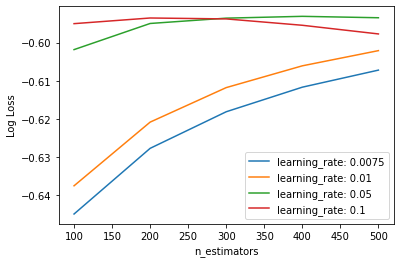

In [91]:
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_learning_rate.png')

In [70]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve


In [92]:
predictions = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

In [93]:
accuracy

0.7315959672817196

In [98]:
def print_metrics(y, y_pred):
  confusion_mtrx = confusion_matrix(y, y_pred)
  print(confusion_mtrx)
  print('number of 1 in y:', sum(y_test))
  print('number of 1 in y_pred:', sum(predictions))

In [102]:
print_metrics(y_test, predictions)

[[2162  636]
 [ 775 1684]]
number of 1 in y: 2459
number of 1 in y_pred: 2320


In [103]:
xgbc0 = XGBClassifier(learning_rate =0.075,
                                    n_estimators=1000,
                                    max_depth=25,
                                    min_child_weight=1,
                                    gamma=0.1,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    nthread=4,
                                    scale_pos_weight=1,
                                    seed=27,
                                    reg_lambda = 0.2
                      )

mode_new = xgbc0.fit(X_train , y_train)


In [104]:
predictions = mode_new.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

In [105]:
print_metrics(y_test, predictions)

[[2017  781]
 [ 942 1517]]
number of 1 in y: 2459
number of 1 in y_pred: 2298


In [95]:
# TN - Actual 0 | Predicted 0 = 2017
# FN - Actual 0 | Predicted 1 = 636
# FP - Actual 1 | Predicted 0 = 775
# TP- Actual 1 | Predicted 1 = 1684

array([[2162,  636],
       [ 775, 1684]])